In [344]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ks_2samp
import joblib

### Read In Data

In [345]:
df = pd.read_parquet('s3://moneygans-data/basketball_nba/starting_money/starting_money_agg/starting_money_all.parquet', engine='pyarrow')[['pos_money','neg_money']]
real_df = df
data = df.values.astype(np.float32)
data.shape

(942, 2)

### Plotting and Test Functions

In [346]:
def plot_real_vs_generated(real_df, gen_df):
    """
    Creates a scatter plot comparing real and generated data points.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
    """
    plt.figure(figsize=(10, 7))
    plt.scatter(real_df['pos_money'], real_df['neg_money'], label='Real Data', color='blue', alpha=0.6)
    plt.scatter(gen_df['pos_money'], gen_df['neg_money'], label='Generated Data', color='orange', alpha=0.6)
    plt.title('Real Data vs. Generated Data')
    plt.xlabel('Positive Money Line')
    plt.ylabel('Negative Money Line')
    plt.legend()
    plt.show()

def plot_feature_distributions(real_df, gen_df):
    """
    Creates histograms comparing the distribution of features between real and generated data.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(real_df['pos_money'], kde=True, color='blue', label='Real', ax=axes[0])
    sns.histplot(gen_df['pos_money'], kde=True, color='orange', label='Generated', ax=axes[0])
    axes[0].set_title('Distribution of Positive Money Line')
    axes[0].legend()

    sns.histplot(real_df['neg_money'], kde=True, color='blue', label='Real', ax=axes[1])
    sns.histplot(gen_df['neg_money'], kde=True, color='orange', label='Generated', ax=axes[1])
    axes[1].set_title('Distribution of Negative Money Line')
    axes[1].legend()
    plt.show()

def perform_ks_test(real_df, gen_df):
    """
    Perform Kolmogorov-Smirnov tests for both marginal distributions and joint distribution.
    Compares real data with generated data.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
    """
    from scipy import stats
    
    # Perform KS test for positive moneyline
    ks_stat_pos, p_value_pos = stats.ks_2samp(real_df['pos_money'], gen_df['pos_money'])
    
    # Perform KS test for negative moneyline  
    ks_stat_neg, p_value_neg = stats.ks_2samp(real_df['neg_money'], gen_df['neg_money'])
    
    # Perform 2D KS test for joint distribution
    real_joint = np.column_stack((real_df['pos_money'], real_df['neg_money']))
    gen_joint = np.column_stack((gen_df['pos_money'], gen_df['neg_money']))
    ks_stat_2d, p_value_2d = stats.ks_2samp(real_joint.ravel(), gen_joint.ravel())
    
    # Print results
    print("Kolmogorov-Smirnov Test Results:")
    print("\nPositive Moneyline:")
    print(f"KS statistic: {ks_stat_pos:.4f}")
    print(f"p-value: {p_value_pos:.4f}")
    print(f"Null hypothesis (distributions are the same): {'Not rejected' if p_value_pos > 0.05 else 'Rejected'}")
    
    print("\nNegative Moneyline:")
    print(f"KS statistic: {ks_stat_neg:.4f}") 
    print(f"p-value: {p_value_neg:.4f}")
    print(f"Null hypothesis (distributions are the same): {'Not rejected' if p_value_neg > 0.05 else 'Rejected'}")
    
    print("\nJoint Distribution:")
    print(f"KS statistic: {ks_stat_2d:.4f}")
    print(f"p-value: {p_value_2d:.4f}")
    print(f"Null hypothesis (distributions are the same): {'Not rejected' if p_value_2d > 0.05 else 'Rejected'}")

def calculate_wasserstein_distances(real_df, gen_df):
    """
    Calculate Wasserstein distances between real and generated distributions
    for both positive and negative moneylines.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
        
    Returns:
        dict: Dictionary containing Wasserstein distances for both distributions
    """
    from scipy.stats import wasserstein_distance
    
    # Calculate Wasserstein distance for positive moneyline
    wd_pos = wasserstein_distance(real_df['pos_money'], gen_df['pos_money'])
    
    # Calculate Wasserstein distance for negative moneyline
    wd_neg = wasserstein_distance(real_df['neg_money'], gen_df['neg_money'])
    
    # Print results
    print("Wasserstein Distance Results:")
    print(f"\nPositive Moneyline: {wd_pos:.4f}")
    print(f"Negative Moneyline: {wd_neg:.4f}")
    
    return {
        'positive': wd_pos,
        'negative': wd_neg
    }


### Generator Architecture

In [347]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)  # Fit and transform the data first
real_data = torch.tensor(scaled_data)
batch_size = 64  # Adjust batch size as needed
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the Generator network with Batch Normalization, Dropout, and more layers
class Generator(nn.Module):
    def __init__(self, noise_dim=10, output_dim=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim),
        )

    def forward(self, z):
        return self.model(z)

# Hyperparameters
noise_dim = 10
n_epochs = 5000  # Increase epochs for better results
lr = 1e-4
n_critic = 5  # Number of critic iterations per generator iteration

# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == 'cuda':
    print("GPU:", torch.cuda.get_device_name(0))
G = Generator(noise_dim=noise_dim, output_dim=2).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))


Using device: cpu


### Loads the saved generator model

In [348]:
# Load the saved model
checkpoint = torch.load('wgan_model.pth')
G.load_state_dict(checkpoint['generator_state_dict'])
optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])


### Generates synthetic data

In [349]:
# Generate synthetic data
with torch.no_grad():
    z = torch.randn(len(real_data), noise_dim).to(device)
    generated_samples = G(z).cpu().numpy()

# Inverse transform the data if normalized
generated_samples = scaler.inverse_transform(generated_samples)
real_data_np = scaler.inverse_transform(real_data.numpy())

# Convert to DataFrames for easier plotting
real_df = pd.DataFrame(real_data_np, columns=['pos_money', 'neg_money'])
gen_df = pd.DataFrame(generated_samples, columns=['pos_money', 'neg_money'])

### Results

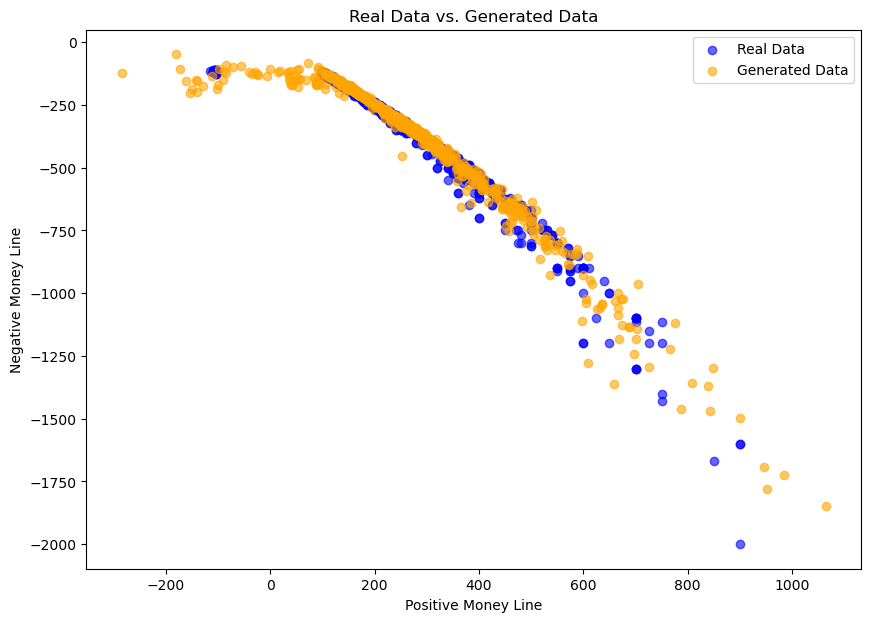

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

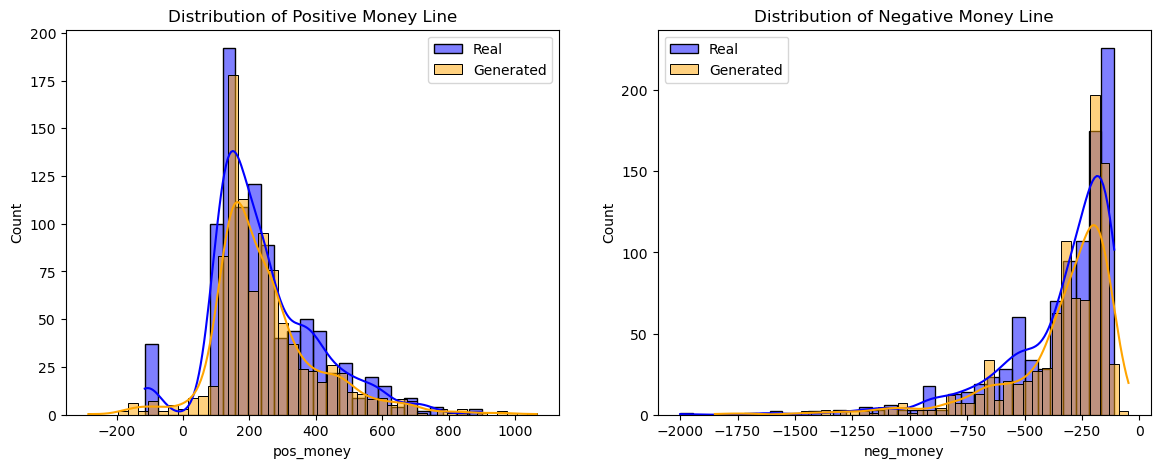

In [350]:
plot_real_vs_generated(real_df, gen_df)
plot_feature_distributions(real_df, gen_df)

In [351]:
perform_ks_test(real_df, gen_df)
print()
calculate_wasserstein_distances(real_df, gen_df)

Kolmogorov-Smirnov Test Results:

Positive Moneyline:
KS statistic: 0.1008
p-value: 0.0001
Null hypothesis (distributions are the same): Rejected

Negative Moneyline:
KS statistic: 0.1030
p-value: 0.0001
Null hypothesis (distributions are the same): Rejected

Joint Distribution:
KS statistic: 0.0547
p-value: 0.0072
Null hypothesis (distributions are the same): Rejected

Wasserstein Distance Results:

Positive Moneyline: 14.7639
Negative Moneyline: 18.4681


{'positive': 14.763940876962781, 'negative': 18.46806711654501}